# Topic Modeling 
This notebook aims to take as input the texts who have been processed and use it to find the most relevants topics and the words that are used for the sentimental analysis.

- Make sure to have 
    - the folder data/spX00/text (where X is 5 or 6) in the repository to be able to run the notebook
    - the notebook pre_processing.ipynb

In [1]:
import os
import re
import pandas as pd
import numpy as np
import import_ipynb
import pre_processing as p
from finbert_embedding.embedding import FinbertEmbedding

import hdbscan
import gensim
import finbert_embedding
import umap.umap_ as umap
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import corpora
from gensim.corpora.dictionary import Dictionary

from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
import pandas as pd


importing Jupyter notebook from pre_processing_final.ipynb


/Users/tatianacogne/opt/anaconda3/envs/res/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package averaged_pe

### Import and process the texts

In [2]:
df = p.import_texts()

Number of articles 19341


### TF-IDF - FiGAS Option 1

In [3]:
def top_n_TFIDF_words(n, texts_processed):
    """Take the top 10 words depending on the score with the TF-IDF."""
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(texts_processed)
    print(X_tfidf.shape)

    # Create dictionnary with all the words contained in the TF-IDF matrix
    dict_w_index = vectorizer.vocabulary_
    dict_index_w = {v: k for k, v in dict_w_index.items()}
    
    n =10
    top_n = []
    for i in range(X_tfidf.shape[0]):
        index = X_tfidf[i,].nonzero()[1]
        words_of_index = [dict_index_w[x] for x in index]
        score_of_index = [X_tfidf[i,x] for x in index]
        x = list(zip(words_of_index,score_of_index))
        x.sort(key=lambda x: -x[1])
        a = [w[0] for w in x[:n]]
        top_n.append(a)
    
    return top_n

In [4]:
#Process the texts and remove the one who are empty 
df['text_processed'] = df.text.apply(lambda x: p.process_figas(x))
df['l'] = df.text_processed.apply(lambda x: len(x))
df[df.l==0].article.values
df = df[df.l>0]

In [5]:
# Find the top 10 words with the option 1 for FiGAS
df['tfidf_top_10_words'] = top_n_TFIDF_words(10, df.text_processed)

(19248, 56495)


In [6]:
# Save the top words found with TF-IDF in a csv with the article ID and ticker
df_csv = pd.DataFrame({'ticker':df.ticker,'article':df.article,'top_n_words':df.tfidf_top_10_words})
df_csv.to_csv("data/sp_500_top_10_words_tfidf_proc_figass_by_corpus.csv")  

### TF-IDF - FiGAS Option 2

In [7]:
def tfidf_by_text(text):
    """Take the top 3 words for each pairs of question and answer and combine all of them."""
    list_sentences = text.split('||')
    out = ['.'.join(list_sentences[k:k+2]) for k in range(0, len(list_sentences), 2)]
    top_3_words = top_n_TFIDF_words(3, out)
    top_words = set(sum(top_3_words, []))
    return top_words

In [8]:
#Process the texts with for the option 2 for FiGAS and remove the one who are empty 
df2 = df.copy()
df2['text_processed'] = df.text.apply(lambda x: p.process_figas2(x))
df2['l'] = df2.text_processed.apply(lambda x: len(x))
df2[df2.l==0].article.values
df2 = df2[df2.l>0]

In [ ]:
# Find the top words with the option 2 for FiGAS
df2['words_top'] = df2.text_processed.apply(lambda x : tfidf_by_text(x))

In [10]:
# Save the top words found with TF-IDF in a csv with the article ID and the tickers
df_csv2 = pd.DataFrame({'ticker':df2.ticker,'article':df2.article,'top_n_words':df2.words_top})
df_csv2.to_csv("data/sp_500_top_10_words_tfidf_proc_figass_by_text.csv")  

## Topic Modeling

### TF-IDF

In [11]:
# Create TF-IDF matrix with the text pre-processed
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df.text_processed)

In [12]:
# Dimensionality reduction and clustering
embeddings = X_tfidf
reducer = umap.UMAP()
umap_embeddings = umap.UMAP(n_components= 25, n_neighbors=25, metric='cosine').fit_transform(embeddings)
cluster = hdbscan.HDBSCAN(min_cluster_size=25,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

print('Number of clusters/topics ', len(set(cluster.labels_)))

Number of clusters/topics  260


To be able to see in 2D the clusters we set n_components to 2 and plot the result.

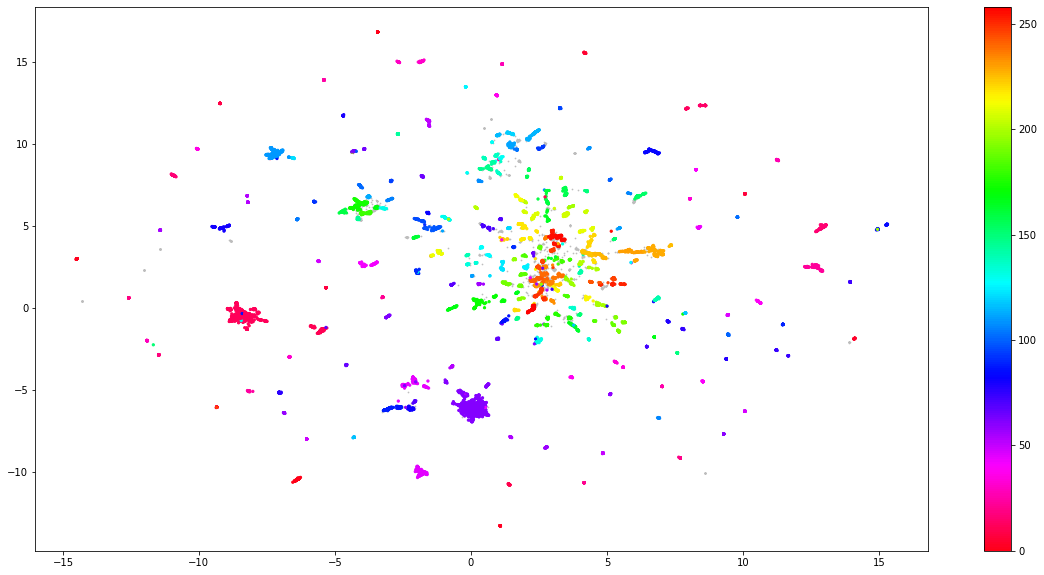

In [13]:
# Prepare data for the visualisation 
umap_data = umap.UMAP(n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r')
plt.savefig('clusters_tfidf.png')
plt.colorbar()

In [14]:
# Group every texts with it's cluster number and group all the texts in cluster togethers
docs_df = pd.DataFrame(df.text_processed.values, columns=["text"])
docs_df['cluster'] = cluster.labels_
docs_df['text_id'] = range(len(docs_df))
docs_per_cluster = docs_df.groupby(['cluster'], as_index = False).agg({'text': ' '.join})

In [15]:
def c_tf_idf(documents, m):
    """Create the TF-IDF matrix for the topic."""
    count = CountVectorizer(stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    "Find the most n relevants words per topic with the TF-IDF matrix."
    words = count.get_feature_names()
    labels = list(docs_per_topic.cluster)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [17]:
def extract_topic_sizes(df):
    """For each cluster count the number of texts in it."""
    topic_sizes = (df.groupby(['cluster'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"cluster": "cluster", "text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

In [18]:
# Create the TF-IDF matrix with clusters and extract the top words for each of them. 
tf_idf, count = c_tf_idf(docs_per_cluster.text.values, m=len(df.text_processed.values))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_cluster, n=20)
topic_sizes = extract_topic_sizes(docs_df)
k=0
for t in topic_sizes.cluster.values:
    if(t!=-1):
        top_n_words[t].sort(key=lambda x:- x[1])
        k +=1
        print('')
        print('Cluster - ',k)
        for i in range(10):
            print(top_n_words[t][i][0])

/Users/tatianacogne/opt/anaconda3/envs/res/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Cluster -  1
deposit
bank
branch
mortgage
origination
loan
lending
banking
offs
provision

Cluster -  2
tenant
rent
leasing
lease
disposition
property
occupancy
cap
redevelopment
square

Cluster -  3
restaurant
guest
menu
dining
food
premise
beef
check
casual
traffic

Cluster -  4
lateral
rig
drilled
completion
pad
acreage
drill
drilling
spacing
frac

Cluster -  5
reinsurance
accident
claim
cat
severity
underwriting
premium
policy
written
frequency

Cluster -  6
node
foundry
nanometer
wafer
logic
tool
memory
fab
advanced
fabs

Cluster -  7
horsepower
fleet
basin
drilling
frac
crew
pumping
idle
spec
tudor

Cluster -  8
hotel
renovation
transient
leisure
select
convention
occupancy
property
room
guest

Cluster -  9
builder
absorption
spec
community
subdivision
entry
buyer
home
house
affordable

Cluster -  10
reinsurance
claim
rating
annuity
statutory
reserve
block
insurance
regulator
policyholder

Cluster -  11
enrollment
campus
graduate
student
tuition
academic
institution
college
scho

### Linear Discriminant Analysis (LDA)
--> supervised learning so we can not use it!

### Latent Semantic Analysis (LSA)

In [19]:
# Define the number of topics or components
num_components=25

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa.fit_transform(X_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

# Print the topics with their terms
terms = vectorizer.get_feature_names()

for doc, component in enumerate(lsa.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:15]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Clusters "+str(doc)+": ",top_terms_list)

/Users/tatianacogne/opt/anaconda3/envs/res/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Clusters 0:  ['year', 'come', 'term', 'thing', 'margin', 'time', 'good', 'first', 'market', 'well', 'one', 'question', 'point', 'number', 'look']
Clusters 1:  ['loan', 'deposit', 'bank', 'asset', 'yield', 'mortgage', 'credit', 'portfolio', 'property', 'fee', 'tenant', 'ratio', 'origination', 'reserve', 'expense']
Clusters 2:  ['store', 'lease', 'brand', 'comp', 'tenant', 'rent', 'consumer', 'traffic', 'retailer', 'restaurant', 'category', 'retail', 'property', 'foot', 'occupancy']
Clusters 3:  ['store', 'would', 'going', 'brand', 'comp', 'like', 'see', 'category', 'next', 'question', 'think', 've', 'consumer', 'channel', 'retail']
Clusters 4:  ['tenant', 'going', 'lease', 'property', 'rent', 'see', 'would', 'patient', 'little', 'think', 'question', 'clinical', 'like', 'leasing', 'bit']
Clusters 5:  ['tenant', 'lease', 'price', 'rent', 'property', 'project', 'foot', 'plant', 'oil', '000', 'inventory', 'leasing', 'gas', 'rig', 'disposition']
Clusters 6:  ['patient', 'study', 'trial', 'cl